In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use('dark_background')

In [3]:
row_data = np.load('../Dataset.npy', mmap_mode='r')

In [4]:
row_data.shape, row_data[:10]

((4669820,),
 memmap(['ur4592644,tt0120884,10,16 January 2005',
         'ur3174947,tt0118688,3,16 January 2005',
         'ur3780035,tt0387887,8,16 January 2005',
         'ur4592628,tt0346491,1,16 January 2005',
         'ur3174947,tt0094721,8,16 January 2005',
         'ur1162550,tt0114891,9,16 January 2005',
         'ur4371033,tt0391198,10,16 January 2005',
         'ur4584306,tt0426568,7,14 January 2005',
         'ur3174947,tt0120601,8,16 January 2005',
         'ur2694867,tt0060196,10,16 January 2005'], dtype='<U43'))

In [5]:
n_records = int(1.0 * len(row_data))

np.random.seed(489)

df = pd.DataFrame(
    data=pd.Series(
        row_data[np.random.choice(len(row_data), n_records, replace=False)])
    .str.split(',').tolist(),
    columns=['user_id', 'movie_id', 'rating', 'date']
)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4669820 entries, 0 to 4669819
Data columns (total 4 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   movie_id  object
 2   rating    object
 3   date      object
dtypes: object(4)
memory usage: 142.5+ MB


In [7]:
df.head()

,user_id,movie_id,rating,date
0,ur2488512,tt0025586,7,1 May 2010
1,ur60496217,tt4425200,4,20 February 2017
2,ur47207197,tt8667956,9,19 May 2020
3,ur0475177,tt0443295,9,25 November 2005
4,ur18827378,tt2124787,4,3 March 2019


In [8]:
df['user_id'] = df['user_id'].astype('|S')
df['movie_id'] = df['movie_id'].astype('|S')
df.drop('date', axis=1, inplace=True)

In [9]:
df.rating.unique()

array(['7', '4', '9', '10', '3', '6', '2', '8', '1', '5'], dtype=object)

In [10]:
df['rating'] = df['rating'].astype(np.uint8)

In [11]:
df.dtypes

user_id      |S11
movie_id     |S10
rating      uint8
dtype: object

In [12]:
*df.isna().sum(), \
    df.duplicated().sum() / len(df)

(0, 0, 0, 0.004865712168777383)

In [13]:
df = df.drop_duplicates(keep=False)

In [14]:
df.describe(include='all')

,user_id,movie_id,rating
count,4626569,4626569,4.626569e+06
unique,1494249,350788,NaN
top,b'ur2467618',b'tt7286456',NaN
freq,24071,10291,NaN
mean,NaN,NaN,6.754548e+00
std,NaN,NaN,2.974137e+00
min,NaN,NaN,1.000000e+00
25%,NaN,NaN,5.000000e+00
50%,NaN,NaN,8.000000e+00
75%,NaN,NaN,9.000000e+00


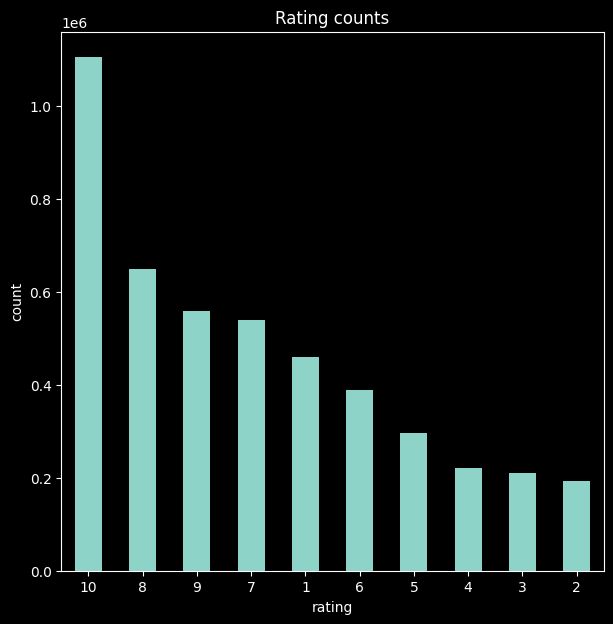

In [15]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))

df.rating.value_counts().plot.bar(ax=ax, rot=0)
ax.set_title('Rating counts')
ax.set_xlabel('rating')
ax.set_ylabel('count')

plt.show()

In [16]:
num_of_ratings_per_user = df.user_id.value_counts(sort=True)
num_of_ratings_per_user

user_id
b'ur2467618'      24071
b'ur20552756'     16790
b'ur2483625'      16691
b'ur0482513'      13199
b'ur2898520'      12675
                  ...  
b'ur118105253'        1
b'ur68975845'         1
b'ur0108645'          1
b'ur120243313'        1
b'ur107956365'        1
Name: count, Length: 1494249, dtype: int64

In [17]:
unique_values = num_of_ratings_per_user.unique()
len(unique_values)

906

In [24]:
top_n = 0.03
users_subset = list(num_of_ratings_per_user.index)[:int(top_n * len(num_of_ratings_per_user))]
len(users_subset)

44827

In [25]:
num_of_ratings_per_movie = df.movie_id.value_counts(sort=True)
len(np.unique(num_of_ratings_per_movie))

1226

In [26]:
movies_subset = list(num_of_ratings_per_movie.index)[:int(top_n * len(num_of_ratings_per_movie))]
len(movies_subset)

10523

In [27]:
chunk_size_users = 8000
chunk_size_movies = 2000

user_dict = {user_id: idx for idx, user_id in enumerate(users_subset)}
movie_dict = {movie_id: idx for idx, movie_id in enumerate(movies_subset)}

D = np.zeros((len(users_subset), len(movies_subset)), dtype=np.uint8)

for start_user in range(0, len(users_subset), chunk_size_users):
    end_user = start_user + chunk_size_users
    users_chunk = users_subset[start_user:end_user]

    for start_movie in range(0, len(movies_subset), chunk_size_movies):
        end_movie = start_movie + chunk_size_movies
        movies_chunk = movies_subset[start_movie:end_movie]

        mask = df.loc[df['user_id'].isin(users_chunk) & df['movie_id'].isin(movies_chunk), ['user_id', 'movie_id', 'rating']]

        if not mask.empty:
            user_indices = mask['user_id'].map(user_dict)
            movie_indices = mask['movie_id'].map(movie_dict)

            D[user_indices, movie_indices] = mask['rating'].values
        else:
            print('empty mask')


In [28]:
np.count_nonzero(D) / D.size * 100

0.2716640982947396

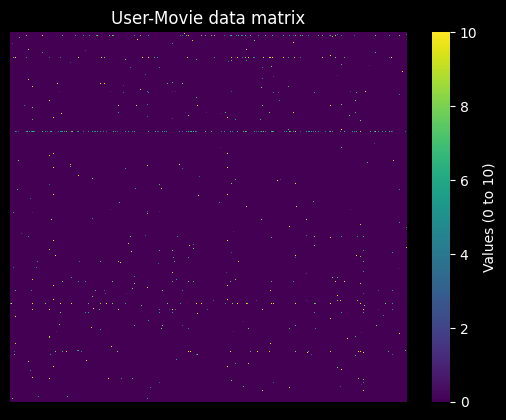

<Figure size 640x480 with 0 Axes>

In [31]:
import seaborn as sns

sample_size = 10000
sample_users = np.random.choice(D.shape[0], size=sample_size, replace=False)
sample_movies = np.random.choice(D.shape[1], size=sample_size, replace=False)

subset_matrix = D[sample_users][:, sample_movies]

sns.heatmap(subset_matrix, cmap='viridis', cbar_kws={'label': 'Values (0 to 10)'}, xticklabels=False, yticklabels=False)

plt.title('User-Movie data matrix')
plt.show()
plt.savefig(f'results/D_matrix_{sample_size}')

In [32]:
np.save('D_matrix.npy', D)